# TS9: Filtrado No Lineal
### Autoras: Noelia Ferrari y Angelina Fantauzzo Fabio

**Consigna**: 


En la TS7 se experimentaron técnicas de filtrado lineal para la mitigación de interferencias en la señal electrocardiográfica (ECG). Tal vez la interferencia que más exigió el diseño de los filtros digitales ha sido el movimiento de línea de base del ECG. La misma se trata de oscilaciones de muy baja frecuencia (< 0.5 Hz) y en ocaciones de alta energía. En esta tarea semanal se analizarán técnicas no lineales de estimación/substracción de la señal de movimiento de base 𝑏(𝑛).

$$
\hat{x}(n) = s(n) - \hat{b}(n)
$$
Siendo 𝑠 la señal de ECG registrada con interferencias, y 𝑥̂ la señal filtrada, una estimación del ECG sin interferencias. 

Se pide que implementeambas estimaciones de 𝑏 detalladas a continuación:


**1) Filtro de mediana**

Se estima:

$$
\hat{b}(n) = \text{med}_{600}\big( \text{med}_{200}( s(n) ) \big)
$$

siendo 𝑚𝑒𝑑(𝑠) el operador de mediana de 𝑡 milisegundos que se aplica sobre la señal 𝑠, es decir:

$$
\hat{b}(n) = \text{med}\big( m[n], m[n-1], \ldots, m[n-600\,f_s] \big)
$$

con:

$$
m[n] = \text{med}\big( s[n], s[n-1], \ldots, s[n-200\,f_s] \big)
$$

Ayuda: puede usar el filtro de mediana de `scipy.signal`.

---
**2) Interpolación mediante splines cúbicos**

A partir de las detecciones provistas en ecg.mat (campo qrs_detections), puede estimar el nivel isoeléctrico, es decir el momento donde la actividad eléctrica cardíaca es aproximadamente nula. El intervalo entre la onda P y Q, es el momento más adecuado para estimar las características de la la interferencia que originan el movimiento de la línea de base. En ese momento el impulso cardíaco es demorado al atravesar el nódulo aurículo-ventricular.


Para cada latido \(n_i\), se define:

$$
m_i = n_i - n_0
$$

El conjunto queda:

$$
\mathcal{S} = \{(m_i,\,s(m_i)) \mid i=1,\ldots,Q\}
$$

La señal de línea de base estimada se obtiene como:

$$
\hat{b}(n) = \text{spline}_3(\mathcal{S}, n),\qquad n=1,\ldots, N
$$

---

**3) Filtro adaptado (matched filter)**

Aplique el concepto de filtro adaptado para diseñar un detector de latidos. Utilice el patrón provisto en el campo qrs_pattern1.

Ayuda: Revise el concepto de filtro adaptado en Wikipedia, o la bibliografía de la materia (Porat 14.4.9).

a) Explique conceptualmente cómo podría realizar un detector de latidos con la señal resultante del filtro adaptado. Discuta la utilidad y limitaciones de este método.

b) Realice la detección de los latidos, comparando las detecciones obtenidas con las que se incluyen en la variable qrs_detections. Proponga alguna métrica (sensibilidad, valor predictivo positivo) para cuantificar la performance del detector.






## Importo librerias y lectura de ECG

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io as sio
import matplotlib.patches as patches
from scipy.signal import medfilt
from scipy.interpolate import CubicSpline
from scipy.spatial import distance


# Lectura de ECG 
fs_ecg = 1000 # Hz
mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg_one_lead = mat_struct['ecg_lead'].flatten()
N = len(ecg_one_lead)

## Introducciones teóricas

Los filtros no lineales son técnicas de procesamiento en las que baiscamente no tratamos con sistemas LTI, o sea que no cumplen ni linealidad ni invarianza en el tiempo necesariamente. Esto basicamente nos rompe la idea de que puedan ser representados mediante la convolucion y no tiene una respuesta en frecuencia como la conocemos. Este TP busca implementar estos filtros para ver su rendimiento. 

### 1) Filtro de mediana

El cálculo de la mediana es una operación no lineal, y por lo tanto el filtrado basado en medianas es un tipo de filtrado no lineal. En ECG, este método se utiliza para estimar la línea de base fisiológica sin verse afectado por los complejos QRS.

La mediana es esencialmente el percentil 50: toma el valor central de una ventana deslizante de tamaño fijo. A diferencia del promedio, no se ve afectada por valores extremos (picos), lo que la hace ideal para separar las componentes lentas de la señal sin que los QRS, que son eventos rápidos y de gran amplitud, distorsionen la estimación.

La clave está en elegir ventanas cuyo ancho sea mayor al ancho típico del QRS, de modo que el complejo quede “afuera” del cálculo y no participe en la mediana. Además, el orden de aplicación de las ventanas es importante: primero se aplica una mediana más corta (200 ms) que suaviza las variaciones rápidas y reduce la influencia del QRS; luego se aplica una ventana más larga (600 ms), que captura de forma más robusta las variaciones lentas de la línea de base.

En conjunto, este filtrado secuencial permite obtener una estimación estable del nivel basal sin distorsionar la forma del QRS ni afectar los bordes abruptos característicos de los latidos.

### Implementación: Filtro de mediana

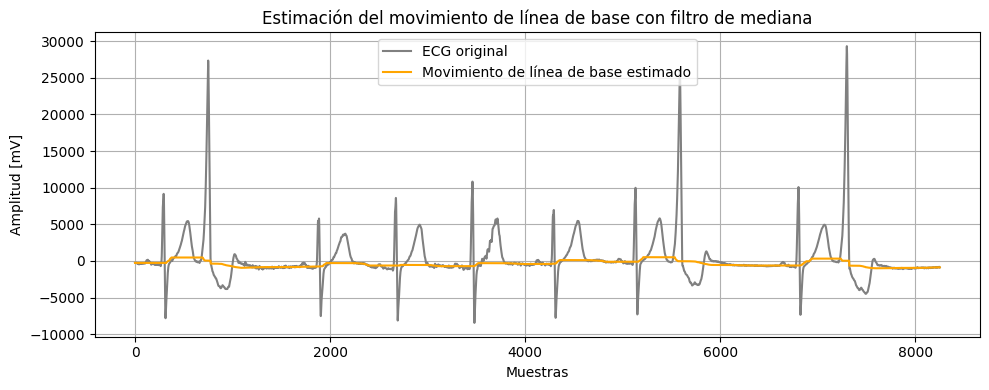

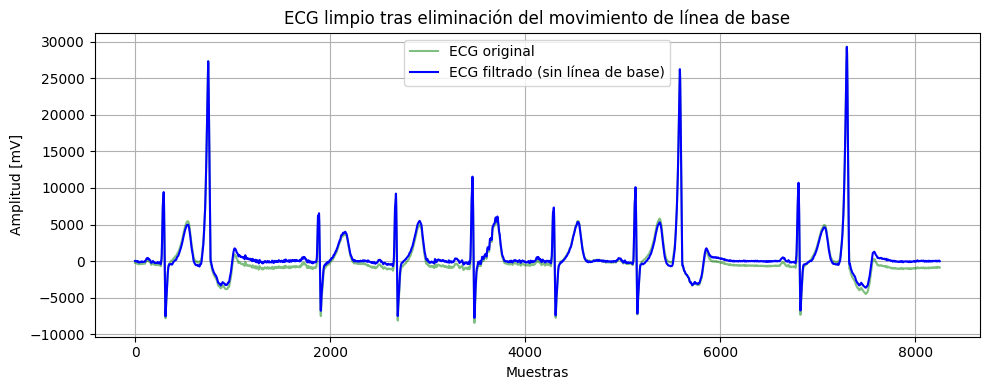

In [18]:
filtro_mediana = medfilt( volume=ecg_one_lead , kernel_size=201) #el volumen es la señal, kernel size es el tiempo en este caso

"""
El kernel size tiene que ser impar porque sino no tiene mitad 
los FIR tipo II eran impares, el retardo es la cantidad de coeficientes menos 2. 
Esto es para que el retardo sea entero. otra razon para elegirlo.
Igualmente esto para sistemas lineales pero igual tiene mas sentido que sea impar

"""

#La salida del filtro la vuelvo a filtrar pero con 600
filtro_mediana = medfilt( volume=filtro_mediana , kernel_size=601) #esto en definitiva devuelve la linea de base. los movimientos en bajas frecuencias

ecg_limpio = ecg_one_lead - filtro_mediana 

# Zoom en una región representativa
ini, fin = 80750, 89000

plt.figure(figsize=(10,4))
plt.plot(ecg_one_lead[ini:fin], label='ECG original', color='gray')
plt.plot(filtro_mediana [ini:fin], label='Movimiento de línea de base estimado', color='orange')
plt.xlabel('Muestras')
plt.ylabel('Amplitud [mV]')
plt.title('Estimación del movimiento de línea de base con filtro de mediana')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ECG limpio
plt.figure(figsize=(10,4))
plt.plot(ecg_one_lead[ini:fin], label='ECG original', color='green', alpha=0.5)
plt.plot(ecg_limpio[ini:fin], label='ECG filtrado (sin línea de base)', color='blue')
plt.xlabel('Muestras')
plt.ylabel('Amplitud [mV]')
plt.title('ECG limpio tras eliminación del movimiento de línea de base')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 2) Interpolación mediante splines cúbicos 

### Comparacion grafica de las dos lineas de base de los dos primeros metodos

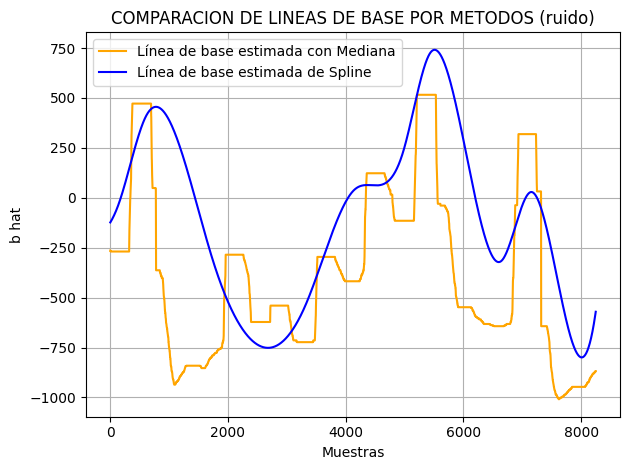

In [6]:
plt.figure()
plt.title('COMPARACION DE LINEAS DE BASE POR METODOS (ruido)')
plt.plot(filtro_mediana[ini:fin] , label='Línea de base estimada con Mediana', color='orange')
plt.plot(b_spline[ini:fin], label='Línea de base estimada de Spline', color='blue')
plt.xlabel('Muestras')
plt.ylabel('b hat')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Ambas tiene una trayectoria similar pero es interesante notar la diferencia de las dos, minetras que el spline es suave y continua, la linea de base de la mediana es todo lo contrario. 

### 3) Filtro adaptado

El filtro adaptado es una técnica de procesamiento óptima para detectar una forma de onda conocida inmersa en ruido.  
Si conocemos un patrón típico del complejo QRS, podemos construir un filtro cuya respuesta impulsiva sea ese mismo patrón invertido en el tiempo. De esta manera, cuando el patrón aparece en la señal ECG, la salida del filtro produce un pico máximo, facilitando la detección de latidos.

Matemáticamente, si el patrón se llama $h[n]$, el filtro adaptado utiliza como respuesta impulsiva:

$$
g[n] = h[N - n - 1]
$$

De esta forma, la operación básica del filtro adaptado es equivalente a una correlación entre la señal y el patrón.

Utilizamos dos formas de aplicar el filtro adaptado, la primera vista en clase usando *lfilter* y la segunda convolucionando. 

**Implementación con `lfilter`**

`lfilter` implementa la ecuación de un sistema LTI:

$$
y[n] = \sum_{k=0}^{M} b[k] \, x[n-k]
$$

Si usamos como coeficientes $b[k]$ la versión invertida del patrón, entonces `lfilter` realiza internamente la correlación necesaria para el filtro adaptado.  


**Implementación con convolución**

Recordemos que la convolución discreta es:

$$
y[n] = \sum_{k} x[k] \, h[n-k]
$$

Si tomamos como núcleo de convolución el patrón invertido, la operación se vuelve equivalente a la correlación del filtro adaptado.

Es decir, la convolución:

$$
y[n] = x[n] * h_{\text{invertido}}[n]
$$

A diferencia de usar lfilter es una forma mas directa de visualizar el concepto de "similaridad" entre señal y patrón.

### Implementación: Filtro Adaptado

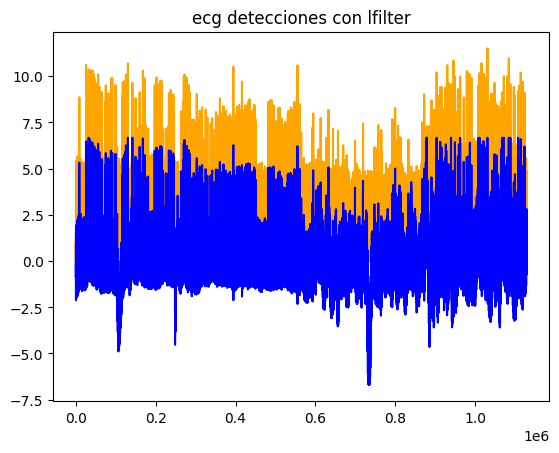

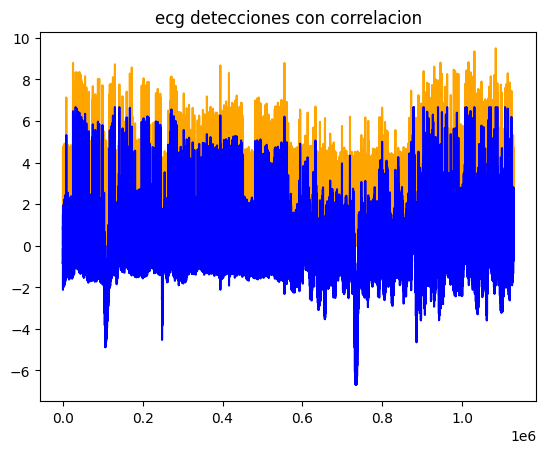

''

In [7]:
patron = mat_struct['qrs_pattern1'].flatten()
#este matron es un pico random del ECG. Cuando grasfique el patron me conviene hacerlo restandole la media
patron_sm = patron - patron.mean() #AREA NETA NULA (USAR ESTE PATRON PARA QUE NO TENGA AREA NETA NEGATIVA)
#el patron lo quiero usar como coeficiente de un filtro uso lfilter
h = patron_sm[::-1]

ecg_detection = signal.lfilter(b=h, a=1, x=ecg_one_lead) #IMPORTANTE INVERTIR EL PATRONES ES PARA DE LA DEFINICION DE UN FILTRO ADAPTADO
ecg_detection = np.abs(ecg_detection)

#Normalizo las dos para que ambas tengas varianza unitaria (sino son muy diferentes y no las puedo comparar)
plt.figure()
plt.plot(ecg_detection/(np.std(ecg_detection)),  color='orange')
plt.plot(ecg_one_lead/(np.std(ecg_one_lead)), color='blue')
plt.title('ecg detecciones con lfilter')
plt.show()

#Al hacerle zoom vemos que el ecg con el patron tiene retardo. El retardo se debe a que el sistema lineal tiene retardo y como no es simetrico va a tener cualq retardo.
#si me adelanto unas muestras del ecg_detection se va a ver medio mejor
#el siguiente paso es detectar los picos, se que son 1903

# Ahora con correlacion!
ecg_detection2 = signal.correlate(ecg_one_lead, h, mode='same')
ecg_detection2 = np.abs(ecg_detection2)               
ecg_detection2 = ecg_detection2 / np.std(ecg_detection2)  #normalizo

plt.figure()
plt.plot(ecg_detection2, color='orange')
plt.plot(ecg_one_lead / np.std(ecg_one_lead), color='blue')
plt.title('ecg detecciones con correlacion')
plt.show()

""""""""""""""

**Busco los picos con la funcion `find_peaks`**

In [8]:
mis_qrs = signal.find_peaks(x = ecg_detection, height=1 , distance=300)[0] #la distacia es un dato fisiologico, dist entre picos. esto es con lfilter
mis_qrs2=signal.find_peaks(x = ecg_detection2, height=1 , distance=300)[0] #esto es con correlacion
qrs_det = mat_struct['qrs_detections'].flatten() #Esto es el patron conocido

**En este siguiente paso vamos a armar una matriz de confusion para detectar si las predicciones fueron buenas, el codigo fue armado por inteleigencia artificial y lo utilizamos todos ya que se armo durante una clase virtual**

In [9]:
#Hago la matriz de confusion para detectar los falsos positivos o negativos
def matriz_confusion_qrs(mis_qrs, qrs_det, tolerancia_ms=150, fs=1000):
    """
    Calcula matriz de confusión para detecciones QRS usando solo NumPy y SciPy
    
    Parámetros:
    - mis_qrs: array con tiempos de tus detecciones (muestras)
    - qrs_det: array con tiempos de referencia (muestras)  
    - tolerancia_ms: tolerancia en milisegundos (default 150ms)
    - fs: frecuencia de muestreo (default 360 Hz)
    """
    
    # Convertir a arrays numpy
    mis_qrs = np.array(mis_qrs)
    qrs_det = np.array(qrs_det)
    
    # Convertir tolerancia a muestras
    tolerancia_muestras = tolerancia_ms * fs / 1000
    
    # Inicializar contadores
    TP = 0  # True Positives
    FP = 0  # False Positives
    FN = 0  # False Negatives
    
    # Arrays para marcar detecciones ya emparejadas
    mis_qrs_emparejados = np.zeros(len(mis_qrs), dtype=bool)
    qrs_det_emparejados = np.zeros(len(qrs_det), dtype=bool)
    
    # Encontrar True Positives (detecciones que coinciden dentro de la tolerancia)
    for i, det in enumerate(mis_qrs):
        diferencias = np.abs(qrs_det - det)
        min_diff_idx = np.argmin(diferencias)
        min_diff = diferencias[min_diff_idx]
        
        if min_diff <= tolerancia_muestras and not qrs_det_emparejados[min_diff_idx]:
            TP += 1
            mis_qrs_emparejados[i] = True
            qrs_det_emparejados[min_diff_idx] = True
    
    # False Positives (tus detecciones no emparejadas)
    fp_index = np.where(~mis_qrs_emparejados)[0] #el cero para que lo devuelva fuera de tupla
    tp_index = np.where(mis_qrs_emparejados)[0]
    FP = np.sum(~mis_qrs_emparejados)
    
    # False Negatives (detecciones de referencia no emparejadas)
    fn_index = np.where(~qrs_det_emparejados)[0]
    FN = np.sum(~qrs_det_emparejados)
    
    # Construir matriz de confusión
    matriz = np.array([
        [TP, FP],
        [FN, 0]  # TN generalmente no aplica en detección de eventos
    ])
    
    return matriz, TP, FP, FN, fp_index, fn_index, tp_index

**Usamos funcion:**

In [11]:
matriz, tp, fp, fn,fp_index, fn_index, tp_index = matriz_confusion_qrs(mis_qrs, qrs_det)
matriz2, tp2, fp2, fn2,fp_index2, fn_index2, tp_index2 = matriz_confusion_qrs(mis_qrs2, qrs_det)

##-------------------------
# METRICAS DE PATRON CON LFILTER
##------------------------
print("Matriz de Confusión (lfilter):")
print(f"           Predicho")
print(f"           Sí    No")
print(f"Real Sí:  [{tp:2d}   {fn:2d}]")
print(f"Real No:  [{fp:2d}    - ]")
print(f"\nTP: {tp}, FP: {fp}, FN: {fn}")

# Calcular métricas de performance
if tp + fp > 0:
    precision = tp / (tp + fp)
else:
    precision = 0

if tp + fn > 0:
    recall = tp / (tp + fn)
else:
    recall = 0

if precision + recall > 0:
    f1_score = 2 * (precision * recall) / (precision + recall)
else:
    f1_score = 0

print(f"\nMétricas CON LFILTER:")
print(f"Precisión: {precision:.3f}")
print(f"Sensibilidad: {recall:.3f}")
print(f"F1-score: {f1_score:.3f}")

##---------------------------------------------------
# METRICAS DE PATRON CON CORRELACION (SON MEJORES!)
##---------------------------------------------------

print("Matriz de Confusión (correlacion):")
print(f"           Predicho")
print(f"           Sí    No")
print(f"Real Sí:  [{tp2:2d}   {fn2:2d}]")
print(f"Real No:  [{fp2:2d}    - ]")
print(f"\nTP: {tp2}, FP: {fp2}, FN: {fn2}")

# Calcular métricas de performance
if tp2 + fp2 > 0:
    precision2 = tp2 / (tp2 + fp2)
else:
    precision2 = 0

if tp2 + fn2 > 0:
    recall2 = tp2 / (tp2 + fn2)
else:
    recall2 = 0

if precision2 + recall2 > 0:
    f1_score2 = 2 * (precision2 * recall2) / (precision2 + recall2)
else:
    f1_score2 = 0

print(f"\nMétricas CON CORRELACION:")
print(f"Precisión: {precision2:.3f}")
print(f"Sensibilidad: {recall2:.3f}")
print(f"F1-score: {f1_score2:.3f}")

Matriz de Confusión (lfilter):
           Predicho
           Sí    No
Real Sí:  [1902    1]
Real No:  [666    - ]

TP: 1902, FP: 666, FN: 1

Métricas CON LFILTER:
Precisión: 0.741
Sensibilidad: 0.999
F1-score: 0.851
Matriz de Confusión (correlacion):
           Predicho
           Sí    No
Real Sí:  [1902    1]
Real No:  [ 3    - ]

TP: 1902, FP: 3, FN: 1

Métricas CON CORRELACION:
Precisión: 0.998
Sensibilidad: 0.999
F1-score: 0.999


En los siguientes graficos se pueden ver cuales fueron los verdaderos positivos y los falsos positivos de las detecciones.

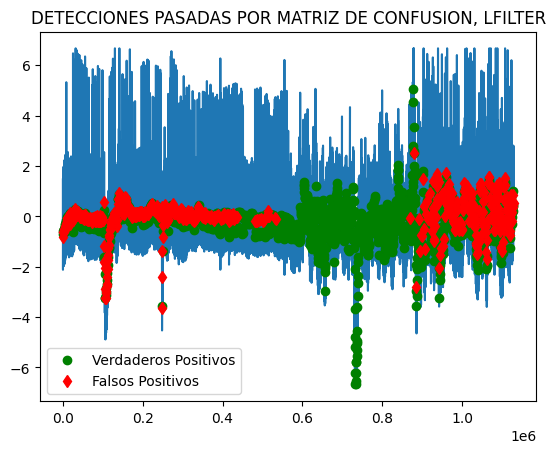

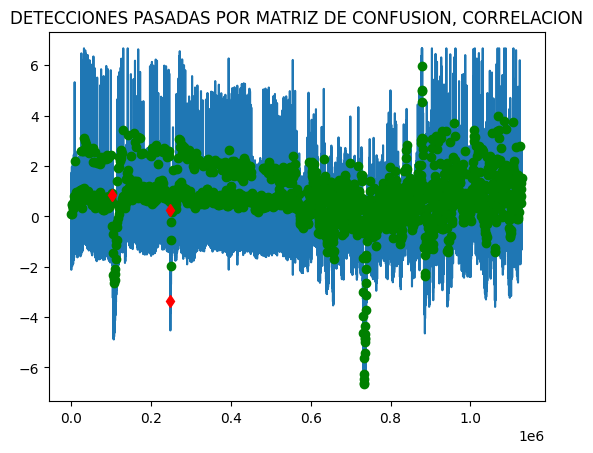

In [12]:
ecg_norm = ecg_one_lead/(np.std(ecg_one_lead))

plt.figure()
plt.plot(ecg_norm)
plt.plot(mis_qrs[tp_index],ecg_norm[mis_qrs[tp_index]], "og", label='Verdaderos Positivos')
plt.plot(mis_qrs[fp_index],ecg_norm[mis_qrs[fp_index]], "dr", label='Falsos Positivos') #valores falsos que estaban en mis qrs
plt.legend()
plt.title('DETECCIONES PASADAS POR MATRIZ DE CONFUSION, LFILTER')
plt.show()


plt.figure()
plt.plot(ecg_norm)
plt.plot(mis_qrs2[tp_index2],ecg_norm[mis_qrs2[tp_index2]], "og", label='Verdaderos Positivos')
plt.plot(mis_qrs2[fp_index2],ecg_norm[mis_qrs2[fp_index2]], "dr", label='Falsos Positivos') #valores falsos que estaban en mis qrs
plt.title('DETECCIONES PASADAS POR MATRIZ DE CONFUSION, CORRELACION')
plt.show()

Se puede ver claramente en estos graficos como el metodo de correlacion fue mas presiso y detecto menos falsos positivos. 

Ahora arreglamos los vectores:

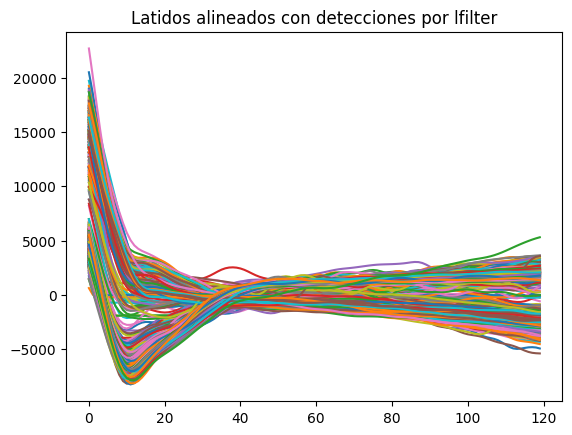

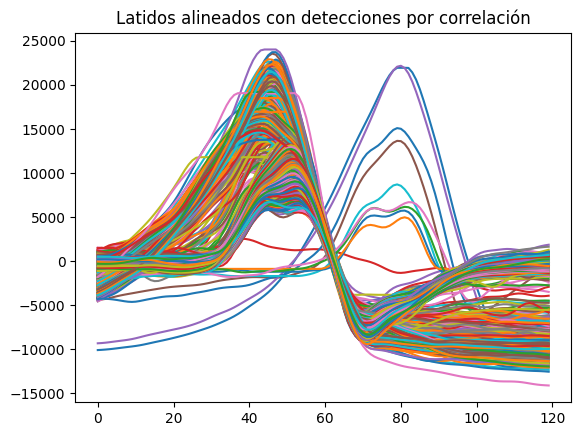

In [14]:
 """
Arreglo mi vector de detecciones eliminando los falsos positivos
"""

mis_qrs_corrected = np.delete(mis_qrs, fp_index)
mis_qrs_corrected = np.concatenate([mis_qrs_corrected, qrs_det[fn_index]])
mis_qrs_corrected = np.sort(mis_qrs_corrected)

qrs_mat = np.array([ecg_one_lead[ii-60:ii+60] for ii in mis_qrs_corrected])

qrs_mat = qrs_mat -np.mean(qrs_mat, axis=1).reshape((-1,1)) #plotea devuelta sin el valor medio

plt.figure()
plt.plot(qrs_mat.transpose()) #con esto alineamos los latidos. Ahora quiero ver que si lo promediamos vamos a encontrar un latido medio con menos ruido
plt.title('Latidos alineados con detecciones por lfilter')
plt.show()

"""
Arreglo mi vector de detecciones CON CORRELACIÓN eliminando los falsos positivos
"""


mis_qrs2_corrected = np.delete(mis_qrs2, fp_index2)
mis_qrs2_corrected = np.concatenate([mis_qrs2_corrected, qrs_det[fn_index2]])
mis_qrs2_corrected = np.sort(mis_qrs2_corrected)
qrs_mat2 = np.array([ecg_one_lead[ii-60:ii+60] for ii in mis_qrs2_corrected])
qrs_mat2 = qrs_mat2 - np.mean(qrs_mat2, axis=1).reshape((-1,1))#quitamos el nivel medio de cada latido (centrado por fila)

#grafico de las realizaciones alineadas (debería verse más prolijo que con lfilter)
plt.figure()
plt.plot(qrs_mat2.transpose())
plt.title('Latidos alineados con detecciones por correlación')
plt.show()

En estos graficos estamos viendo las realizaciones alineadas, es una forma visual de ver que tan bien estan funcionando nuestros filtros. 
En el primer gráfico, correspondiente a la implementación con lfilter,se ve como los latidos no quedan perfectamente alineados entre sí, algunos picos están desplazados y la forma promedio no es tan clara.  Además, el máximo aparece cerca de las 20 ms, que no es donde debería ubicarse fisiológicamente el pico del complejo QRS. Esto sucede porque lfilter implementa una convolución causal, lo que introduce un retardo fijo en la salida y desplaza la señal hacia adelante.
En cambio, en el segundo gráfico las realizaciones se superponen casi perfectamente. Los complejos QRS aparecen centrados alrededor de los 50–60 ms, que es donde corresponde según la duración típica del patrón que estamos usando. Esto ocurre porque la correlación identifica directamente el punto de máxima similitud entre el patrón y la señal, sin el corrimiento temporal que introduce la causalidad de lfilter. Por eso la alineación es mucho más precisa y la forma promedio resulta más clara y estable.

# Conclusiones

En este trabajo probamos tres métodos distintos para procesar el ECG, la mediana y el spline para limpiar la línea de base, y el filtro adaptado para detectar los latidos

El filtro de mediana resultó ser el método más simple y directo. Como la mediana es una operación no lineal, no se deja afectar por los complejos QRS, que son picos muy cortos y de mucha energía. Eso hace que se preserve bien la forma del latido mientras se elimina el movimiento de línea de base. La desventaja del metodo es el alto costo computacional que tiene. Para solucionar esto se podria utilizar la tecnica de diezmado. 

Por otro lado, el spline reconstruye la línea de base a partir de puntos donde sabemos que el ECG debería estar en un nivel casi isoeléctrico (sin actividad cariaca por la tanto donde deberian estas las bajas frecuencias). Esto genera una estimación mucho más suave y fisiológica, pero su correcto desempeño depende de que las detecciones QRS estén bien ubicadas. 

Por ultimo, el filtro adaptado se usó para detectar latidos, no para filtrar la línea de base. La idea es comparar el ECG con un patrón típico de QRS. Cuando lo implementamos con lfilter vimos que los picos quedaban corridos, porque lfilter es causal y desplaza todo. En cambio, usando correlación directa, las detecciones quedaron mucho mejor alineadas y la forma promedio se muy clara. La desventaja es que la correlación es más pesada computacionalmente. 

# Bonus

💎 Proponga alguna mejora a los estimadores de la señal  𝑏, como por ejemplo usar las técnicas multirate. 

Como se menciono en las conclusiones, para bajar el costo computacional de los filtros no lineales utilizar un downsampling (diezmado) seria una buena estrategia. 

💎 ¿Podría funcionar el detector basado en el filtro adaptado con un latido perteneciente a otro registro o paciente?

Podría funcionar, pero las chances de fallo son altas. Como el filtro adaptado se basa en un patrón conocido para construir el detector, usar un latido de otro paciente puede generar errores. Cada persona tiene un ECG ligeramente distinto, incluso, ni siquiera dos latidos de uno mismo son exactamente iguales. Si las características cardíacas y condiciones de salud del otro paciente son muy parecidas, el detector tal vez funcione, pero no es lo recomendable. El filtro adaptado siempre rinde mejor cuando el patrón está bien ajustado a la señal real donde se usa. Si el template no coincide en duración, amplitud o morfología, la correlación baja y se pierde precisión en las detecciones. Por eso, lo ideal es construir el patrón a partir del mismo registro donde se va a aplicar el detector.